In [141]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

In [10]:
def do_graph_random_walks(adj_matrix, edge_indices, num_walks, walk_length):
    num_nodes = adj_matrix.shape[0]
    nodes = np.arange(num_nodes)
    trajectories = []
    for i in range(num_walks):
        trajectory = []
        curr_node = np.random.choice(nodes).item()
        for j in range(walk_length):
            next_node = np.random.choice(np.where(adj_matrix[curr_node] == 1)[0]).item()
            trajectory.append((curr_node, edge_indices[(curr_node, next_node)], next_node))
            curr_node = next_node
        trajectories.append(trajectory)
    return np.array(trajectories)

In [11]:
def gen_random_graph(n_nodes=32, min_degree=2, max_degree=5):
    degrees = np.random.randint(min_degree, max_degree + 1, (n_nodes,))
    if degrees.sum() % 2 != 0:
        adjust_idx = np.random.randint(n_nodes)
        if degrees[adjust_idx] == min_degree:
            degrees[adjust_idx] += 1
        elif degrees[adjust_idx] == max_degree:
            degrees[adjust_idx] -= 1
        else:
            adj = np.random.choice(np.array([-1, 1]))
            degrees[adjust_idx]=degrees[adjust_idx] + adj

    rem_degrees = np.copy(degrees)

    adj_matrix = np.zeros((n_nodes, n_nodes), dtype=np.uint8)
    edges = []
    edge_indices = {}
    edge_idx = 0
    while rem_degrees.sum() != 0:
        i = np.argmax(rem_degrees).item()
        rem_degrees_gz = rem_degrees > 0
        rem_degrees_not_argmax = np.arange(rem_degrees.size) != i
        pending_edges = np.where(rem_degrees_gz & rem_degrees_not_argmax)[0]
        j = np.random.choice(pending_edges).item()

        # find a better way to do this?
        if (i, j) in edges:
            continue

        edges.append((i,j))
        edge_indices[(i,j)] = edge_idx
        edge_idx += 1
        edges.append((j,i))
        edge_indices[(j,i)] = edge_idx
        edge_idx += 1
        rem_degrees[i] -= 1
        rem_degrees[j] -= 1

    for i, j in edges:
        adj_matrix[i, j] = 1

    return adj_matrix, edge_indices

In [13]:
adj_matrix, edge_indices = gen_random_graph()
num_walks = 200
walk_length = 32
trajectories = do_graph_random_walks(adj_matrix, edge_indices, num_walks, walk_length)

In [215]:
n_obs = adj_matrix.shape[0]
n_act = len(edge_indices)
emb_dim = 1000
Q_init_stddev = 1.0
V_init_stddev = 0.1
W_init_stddev = 0.1
eta_q = 0.1
eta_v = 0.01
eta_w = 0.01
num_epochs = 10

In [273]:
np.random.seed(0)
Q = np.random.normal(size=(emb_dim, n_obs)) * Q_init_stddev
V = np.random.normal(size=(emb_dim, n_act)) * V_init_stddev
W = np.random.normal(size=(n_act, emb_dim)) * W_init_stddev

In [221]:
num_trajectories = trajectories.shape[0]
mses1 = []
for epoch in range(num_epochs):
    print(f"epoch {epoch}")
    for traj_idx in range(num_trajectories):
        nodes = trajectories[traj_idx, :, 0]
        edges = trajectories[traj_idx, :, 1]
        next_nodes = trajectories[traj_idx, :, 2]

        s_curr_DxL = Q[:, nodes]
        s_next_DxL = Q[:, next_nodes]

        s_diff_DxL = s_next_DxL - s_curr_DxL
        pred_err_DxL = s_diff_DxL - V[:, edges]

        V[:, edges] += eta_v * pred_err_DxL
        Q[:, next_nodes] += - eta_q * pred_err_DxL
        W[edges, :] += eta_w * s_diff_DxL.T
        mses1.append((pred_err_DxL ** 2).mean())

epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9


In [274]:
num_trajectories = trajectories.shape[0]
mses2 = []
for epoch in range(num_epochs):
    print(f"epoch {epoch}")
    for traj_idx in range(num_trajectories):
        nodes = trajectories[traj_idx, :, 0]
        edges = trajectories[traj_idx, :, 1]
        next_nodes = trajectories[traj_idx, :, 2]
        
        cur_obs = np.zeros((Q.shape[1], len(nodes)))
        for idx, node in enumerate(nodes):
            cur_obs[node, idx] = 1
        next_obs = np.zeros((Q.shape[1], len(next_nodes)))
        for idx, node in enumerate(next_nodes):
            next_obs[node, idx] = 1
        actions = np.zeros((V.shape[1], len(edges)))
        for idx, edge in enumerate(edges):
            actions[edge, idx] = 1

        s_curr_DxL = Q@cur_obs
        s_next_DxL = Q@next_obs

        s_diff_DxL = s_next_DxL - s_curr_DxL
        pred_err_DxL = s_diff_DxL - V@actions

        V += eta_v * pred_err_DxL@actions.T
        Q += eta_q * pred_err_DxL@(- next_obs).T
        W += eta_w * actions@s_diff_DxL.T
        mses2.append((pred_err_DxL ** 2).mean())

epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9


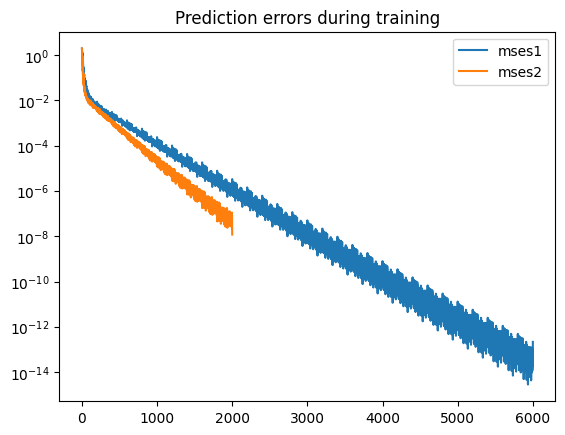

In [275]:
fig, ax = plt.subplots()
ax.plot(mses1, label='mses1')
ax.plot(mses2, label='mses2')
ax.set_title('Prediction errors during training')
ax.set_yscale('log')
plt.legend()
plt.show()
plt.close(fig)

In [276]:
def CML_planner(start, goal, obs_size):
    a_record = []
    o_record = []
    loc = int(start)
    for i in range(obs_size):
        o_record.append(loc)
        if loc==goal:
            return i, o_record
        delta = Q[:,goal] - Q[:,loc]  # TODO: start and goal are one-hot vector
        avail_nodes = np.where(adj_matrix[loc] == 1)[0]  # int64
        avail_actions = [edge_indices[(loc, int(next_node))] for next_node in avail_nodes]
        utility = delta.T@V[:, avail_actions]
        best_id = np.argmax(utility)
        best_action = avail_actions[best_id]
        loc = int(avail_nodes[best_id])
        a_record.append(best_action)
    return i, o_record

In [277]:
graph = nx.from_numpy_array(adj_matrix, create_using=nx.DiGraph())
start_id = 10
goal_id = 30
steps, o_record = CML_planner(start_id, goal_id, n_obs)
dijkstra_path = nx.shortest_path(graph, source=start_id, target=goal_id)
print(o_record, dijkstra_path)
dijkstra_steps = len(dijkstra_path) - 1

[10, 19, 7, 21, 2, 30] [10, 11, 9, 29, 30]


In [259]:
delta = Q[:,goal_id] - Q[:,start_id]

In [270]:
avail_nodes = np.where(adj_matrix[start_id] == 1)[0]
avail_nodes

np.int64(8)

In [264]:
avail_actions = [edge_indices[(start_id, int(next_node))] for next_node in avail_id]
avail_actions

[0, 35, 32, 10, 41]

In [265]:
utility = delta.T@V[:, avail_actions]
utility

array([-0.1081222 ,  6.31474811, -0.04077369, 16.6063433 ,  4.42656941])

In [267]:
best_action = avail_actions[np.argmax(utility)]
best_action

10

In [ ]:
edge_indices.values

In [250]:
id = np.argmax((delta.T@V)[avail_edge])
id

np.int64(4)

In [247]:
avail_id[id]

np.int64(30)

In [280]:
N_goal = 1000
cml_distance = []
dijkstra_distance = []
graph = nx.from_numpy_array(adj_matrix, create_using=nx.DiGraph())
for _ in range(N_goal):
    start_id = np.random.randint(0, n_obs)
    goal_id = np.random.randint(0, n_obs)
    steps, o_record = CML_planner(start_id, goal_id, n_obs)
    dijkstra_path = nx.shortest_path(graph, source=start_id, target=goal_id)
    # print(o_record, dijkstra_path)
    dijkstra_steps = len(dijkstra_path) - 1
    cml_distance.append(steps)
    dijkstra_distance.append(dijkstra_steps)
# cml_distance, dijkstra_distance
np.mean(cml_distance), np.mean(dijkstra_distance)

(np.float64(3.595), np.float64(3.042))

In [ ]:

def test_model(model, env, print_results=True):
    N_nodes = model.o_size
    dis = []
    D_dis = []
    N_goal = 1000
    graph = nx.from_numpy_matrix(env.adj_matrix.cpu().numpy(), create_using=nx.DiGraph())
    for i in range(N_goal):
        start_idx = torch.randint(N_nodes, (1,))[0]
        goal_idx = torch.randint(N_nodes, (1,))[0]
        with torch.no_grad():
            steps, o_record = model.plan(start_idx, goal_idx, env, False)
        D_path = nx.shortest_path(graph, source=int(start_idx.cpu()), target=int(goal_idx.cpu()))
        D_steps = len(D_path) - 1
        dis.append(steps)
        D_dis.append(D_steps)

    # Convert lists to tensors and move them to GPU
    dis = torch.tensor(dis).float()
    D_dis = torch.tensor(D_dis).float()
    mask = dis != (N_nodes-1)
    mean_CML = torch.mean(dis).item()
    std_CML = torch.std(dis).item()
    mean_Dij = torch.mean(D_dis).item()
    std_Dij = torch.std(D_dis).item()
    if print_results:
        print('CML steps:', str(mean_CML)[:6], ', Success Rate:', str((mask.sum() / N_goal * 100).item())[:6] + '%',
          ', Dij steps:', str(mean_Dij)[:6], ', Percentage worse:', str((mean_CML / mean_Dij - 1) * 100)[:6] + '%')
        print('CML std: ', str(std_CML)[:6], ' Dij std: ', str(std_Dij)[:6])
    else:
        return mean_CML